In [1]:
#################
#### IMPORTS ####
#################

# Arrays
import numpy as np

# Deep Learning stuff
import torch
import torchvision
import torchvision.transforms as transforms

# Images display and plots
import matplotlib.pyplot as plt

# Fancy progress bars
import tqdm.notebook as tq

# Tensor Network Stuff
%config InlineBackend.figure_formats = ['svg']
import quimb.tensor as qtn # Tensor Network library
import quimb


In [2]:
import sys
sys.path.insert(0, '../')
# My functions
from TNutils import *


### 1. Handling MNIST images

Get MNIST data
1. Actually download data
2. Flatten each image
3. Normalize [0,255] -> [0,1]
4. Trasform from grayscale to binary images [0,1] -> {0,1}

In [3]:
train_set, test_set = get_data()


In [4]:
print('Shape of the training set: {}'.format(train_set.shape) )
print('Shape of the test set:     {}'.format(test_set.shape) )


Shape of the training set: (1000, 784)
Shape of the test set:     (100, 784)


Example of an image:

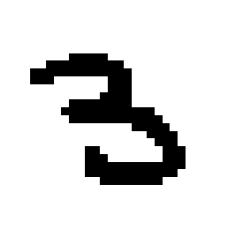

In [5]:
plot_img(train_set[1])


Further on, we will like to get rid parts of the image and reconstruct them.
There is a function for partially removing parts of the image in the test set:

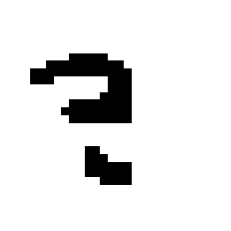

In [6]:
plot_img( partial_removal_img(train_set[1], fraction = .4, axis = 1))

### 2. MPS 

1. Create an MPS network
2. Canonicalize towards the second tensor
3. Rename indexes (in a readable form)

In [7]:
toymps = initialize_mps(Ldim=10, bdim=10)

Inspect shape/canonicalization

In [8]:
toymps.show()

 2 10 10 10 10 10 8 4 2 
>─●──<──<──<──<──<─<─<─<
│ │  │  │  │  │  │ │ │ │


Inspect indexes

In [9]:
toymps.tensors

(Tensor(shape=(2, 2), inds=('i0', 'v0'), tags=oset(['I0'])),
 Tensor(shape=(2, 10, 2), inds=('i0', 'i1', 'v1'), tags=oset(['I1'])),
 Tensor(shape=(10, 10, 2), inds=('i1', 'i2', 'v2'), tags=oset(['I2'])),
 Tensor(shape=(10, 10, 2), inds=('i2', 'i3', 'v3'), tags=oset(['I3'])),
 Tensor(shape=(10, 10, 2), inds=('i3', 'i4', 'v4'), tags=oset(['I4'])),
 Tensor(shape=(10, 10, 2), inds=('i4', 'i5', 'v5'), tags=oset(['I5'])),
 Tensor(shape=(10, 8, 2), inds=('i5', 'i6', 'v6'), tags=oset(['I6'])),
 Tensor(shape=(8, 4, 2), inds=('i6', 'i7', 'v7'), tags=oset(['I7'])),
 Tensor(shape=(4, 2, 2), inds=('i7', 'i9', 'v8'), tags=oset(['I8'])),
 Tensor(shape=(2, 2), inds=('i9', 'v9'), tags=oset(['I9'])))

In [10]:
mps = initialize_mps(bdim=30)

I developed two forms to compute the contraction of the mps and an image 

namely psi(v)

1. (SLOW) actually creates the network of the image and contract it 
2. einsums

the two methods outputs the same result, but the second is way faster

In [11]:
%%time

slow_psi = quimb_transform_img2state(train_set[0]) @ mps

CPU times: user 1.99 s, sys: 3.38 ms, total: 2 s
Wall time: 2 s


In [12]:
%%time 

fast_psi = computepsi(mps, train_set[0])

CPU times: user 11.6 ms, sys: 0 ns, total: 11.6 ms
Wall time: 10.7 ms


### 3. Learning

In [28]:
imgs = train_set[:2]
mps = initialize_mps(bdim=30)


In [29]:
# Compute probability of the first image of the training set of the untrained network
computepsi(mps,imgs[0])**2

1.7022363098743328e-251

In [30]:
learning_epoch(mps, imgs, 3, 0.1)


  0%|          | 0/1562 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

  0%|          | 0/1562 [00:00<?, ?it/s]

In [ ]:
# YOU CAN GET PROBABILITIES MORE THAN ONE, WE NEED TO RE-NORMALIZE THE MPS
mps = mps / mps.norm()


In [ ]:
# Compute probability of the first image of the training set of the trained network
computepsi(mps,imgs[0])**2


In [ ]:
# Compute probability of random noise from the trained network
computepsi(mps,np.random.randint(0,2,(784)) )**2


In [23]:
computeNLL(mps, imgs)

31.233349257959436

In [24]:
computepsi(mps,imgs[0])**2

1.5069859864582443e-17

### 4. Generation

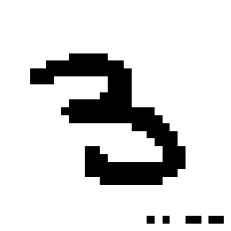

In [33]:
gen = generate_sample(mps)
gen.appendleft(0) # I didn't bother to apply the last step in the loop of the generation function
plot_img(gen)